# Optimization of TLN using differentiable simulation - with mismatch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Library imports
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import diffrax as dr
import sympy as sp

from typing import Dict

In [3]:
# Local imports
from ark.cdg.cdg import CDG, CDGNode
from ark.compiler import ArkCompiler
from ark.rewrite import RewriteGen, SympyRewriteGen
from ark.solver import SMTSolver
from ark.specification.cdg_types import NodeType, EdgeType
from ark.validator import ArkValidator
from spec import pulse_sympy
from tln_example import create_tline_branch, IdealV, IdealI, IdealE

## Generate a TLN graph from specification

--- block colors ---
--- line colors ---


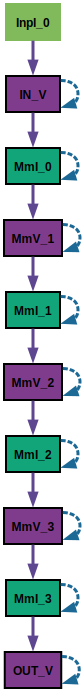

In [4]:
from examples.tln.tln_example import make_full_graph

branch_args = {
    "line_len": 4,
    "branch_stride": 4,
    "branches_per_node": 0,
    "branch_len": 4,
    "branch_offset": 0,
}

# itl_small_graph, _, _ = create_tline_branch(
#     IdealV, IdealI, lambda: IdealE(), **branch_args
# )
# itl_small_graph
graph, spec = make_full_graph(mismatch=True,
                              branch_args_override=branch_args)

from ark.visualize.graphviz_gen import cdg_to_graphviz_display
cdg_to_graphviz_display(cdg_lang=spec, cdg=graph)

Now we have a graph with representing the TLN with certain arguments, and can compile it to SymPy expressions.

In [5]:
compiler = ArkCompiler(rewrite=SympyRewriteGen())
sympy_pairs = compiler.compile_sympy(cdg=graph, cdg_spec=spec, help_fn=[])

Compiling order 1 nodes: 100%|██████████| 9/9 [00:00<00:00, 232.52it/s]


In [6]:
sympy_pairs

[(ddt_IN_V,
  -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c + MmE_8_wt*(-IN_V*InpI_0_g + InpI_0_fn(time))/IN_V_c),
 (ddt_MmI_0,
  IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 (ddt_MmI_1,
  MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 (ddt_MmI_2,
  MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 (ddt_MmI_3,
  MmE_6_wt*MmV_3/MmI_3_l - MmE_7_ws*OUT_V/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 (ddt_MmV_1,
  MmE_1_wt*MmI_0/MmV_1_c - MmE_2_ws*MmI_1/MmV_1_c - MmV_1*MmV_1_g/MmV_1_c),
 (ddt_MmV_2,
  MmE_3_wt*MmI_1/MmV_2_c - MmE_4_ws*MmI_2/MmV_2_c - MmV_2*MmV_2_g/MmV_2_c),
 (ddt_MmV_3,
  MmE_5_wt*MmI_2/MmV_3_c - MmE_6_ws*MmI_3/MmV_3_c - MmV_3*MmV_3_g/MmV_3_c),
 (ddt_OUT_V, MmE_7_wt*MmI_3/OUT_V_c - OUT_V*OUT_V_g/OUT_V_c)]

We can now convert these into a set of differential equations, using some amount of parsing.

In [7]:
def collapse_derivative(pair: tuple[sp.Symbol, sp.Expr]) -> sp.Eq:
    """Turns tuple of derivative + sympy expression into a single sympy equation."""
    if (var_name := pair[0].name).startswith('ddt_'):
        symbol = sp.symbols(var_name[4:])
        equation = sp.Eq(sp.Derivative(symbol, sp.symbols('time')), pair[1])
        return equation.subs(sp.symbols('time'), sp.symbols('t'))
    else:
        raise ValueError("Not a derivative expression.")
sympy_eqs = [collapse_derivative(pair) for pair in sympy_pairs]
sympy_eqs

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c + MmE_8_wt*(-IN_V*InpI_0_g + InpI_0_fn(t))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_2, t), MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), MmE_6_wt*MmV_3/MmI_3_l - MmE_7_ws*OUT_V/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(Derivative(MmV_1, t), MmE_1_wt*MmI_0/MmV_1_c - MmE_2_ws*MmI_1/MmV_1_c - MmV_1*MmV_1_g/MmV_1_c),
 Eq(Derivative(MmV_2, t), MmE_3_wt*MmI_1/MmV_2_c - MmE_4_ws*MmI_2/MmV_2_c - MmV_2*MmV_2_g/MmV_2_c),
 Eq(Derivative(MmV_3, t), MmE_5_wt*MmI_2/MmV_3_c - MmE_6_ws*MmI_3/MmV_3_c - MmV_3*MmV_3_g/MmV_3_c),
 Eq(Derivative(OUT_V, t), MmE_7_wt*MmI_3/OUT_V_c - OUT_V*OUT_V_g/OUT_V_c)]

Now we need to substitute the forcing function `InpI_0_fn` into a pulse function (a piecewise function defined in SymPy).

In [8]:
t = sp.symbols('t')
InpI_0_fn = sp.Function('InpI_0_fn')
replaced_function = sympy_eqs[0].subs(InpI_0_fn(t), pulse_sympy(t))
replaced_function

Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c + MmE_8_wt*(-IN_V*InpI_0_g + Piecewise((0, Mod(t, 1) < 5.0e-9), (200000000.0*(Mod(t, 1)), Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c)

In [9]:
sympy_eqs_expanded = [replaced_function if i == 0 else f for i, f in enumerate(sympy_eqs)]

In [10]:
sympy_eqs_expanded

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c + MmE_8_wt*(-IN_V*InpI_0_g + Piecewise((0, Mod(t, 1) < 5.0e-9), (200000000.0*(Mod(t, 1)), Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_2, t), MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), MmE_6_wt*MmV_3/MmI_3_l - MmE_7_ws*OUT_V/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(Derivative(MmV_1, t), MmE_1_wt*MmI_0/MmV_1_c - MmE_2_ws*MmI_1/MmV_1_c - MmV_1*MmV_1_g/MmV_1_c),
 Eq(Derivative(MmV_2, t), MmE_3_wt*MmI_1/MmV_2_c - MmE_4_ws*MmI_2/MmV_2_c - MmV_2*MmV_2_g/MmV_2_c),
 Eq(Derivative(MmV_3, t), MmE_5_wt*MmI_2/MmV_3_c - MmE_6_ws*MmI_3/MmV_3_c - MmV_3*MmV_3_g/MmV_3_c),
 Eq(Derivative(OUT_V, t), MmE_7_wt*MmI_3/OUT_V_c 

In [11]:
# Find all the LHS variables in the set of equations
lhs_vars = [list(eq.lhs.free_symbols)[0] for eq in sympy_eqs_expanded]
lhs_vars

[IN_V, MmI_0, MmI_1, MmI_2, MmI_3, MmV_1, MmV_2, MmV_3, OUT_V]

In [26]:
# Figure out which parameters are necessary to evaluate the equations
param_vars = [eq.free_symbols - set(lhs_vars) for eq in sympy_eqs_expanded]
all_param_vars = set().union(*param_vars)
all_param_vars.remove(sp.symbols('t'))
del param_vars
print(f'All parameters:\n{", ".join(map(str, all_param_vars))}')

All parameters:
MmE_5_ws, MmE_5_wt, MmV_3_g, MmE_1_wt, MmV_2_c, MmE_2_wt, MmE_0_ws, MmV_1_c, MmV_3_c, MmI_2_l, MmI_2_r, InpI_0_g, MmE_0_wt, MmV_2_g, IN_V_g, OUT_V_g, MmI_0_l, MmI_1_l, MmI_3_r, MmE_3_ws, MmE_7_ws, MmE_8_wt, MmI_1_r, MmE_4_wt, MmE_4_ws, MmE_1_ws, MmI_0_r, IN_V_c, OUT_V_c, MmV_1_g, MmE_2_ws, MmE_6_ws, MmE_3_wt, MmI_3_l, MmE_7_wt, MmE_6_wt


In [18]:
# Now we gather the parameters necessary from the respective nodes in the graph
def get_param_from_dict(param_name: str) -> float:
    element_name = '_'.join(param_name.split('_')[:-1])
    param_name = param_name.split('_')[-1]
    return graph_param_dict[element_name][param_name]

# Collect all node parameters into a dictionary with dictionary values
node_param_dict = {node.name: node.attrs for node in graph.nodes}
edge_param_dict = {edge.name: edge.attrs for edge in graph.edges}
graph_param_dict = node_param_dict | edge_param_dict

# Gather all necessary parameters in a flat dictionary
param_dict = {k: get_param_from_dict(k.name) for k in all_param_vars}
param_dict

{MmE_5_ws: 1.0,
 MmE_5_wt: 1.0,
 MmV_3_g: 0.0,
 MmE_1_wt: 1.0,
 MmV_2_c: 1e-09,
 MmE_2_wt: 1.0,
 MmE_0_ws: 1.0,
 MmV_1_c: 1e-09,
 MmV_3_c: 1e-09,
 MmI_2_l: 1e-09,
 MmI_2_r: 0.0,
 InpI_0_g: 1.0,
 MmE_0_wt: 1.0,
 MmV_2_g: 0.0,
 IN_V_g: 0.0,
 OUT_V_g: 1.0,
 MmI_0_l: 1e-09,
 MmI_1_l: 1e-09,
 MmI_3_r: 0.0,
 MmE_3_ws: 1.0,
 MmE_7_ws: 1.0,
 MmE_8_wt: 1.0,
 MmI_1_r: 0.0,
 MmE_4_wt: 1.0,
 MmE_4_ws: 1.0,
 MmE_1_ws: 1.0,
 MmI_0_r: 0.0,
 IN_V_c: 1e-09,
 OUT_V_c: 1e-09,
 MmV_1_g: 0.0,
 MmE_2_ws: 1.0,
 MmE_6_ws: 1.0,
 MmE_3_wt: 1.0,
 MmI_3_l: 1e-09,
 MmE_7_wt: 1.0,
 MmE_6_wt: 1.0}

In [19]:
# Gather initial values for the LHS variables
# TODO(marcelroed): Currently all at zero -- should this change?
lhs_init_dict = {k: 0.0 for k in lhs_vars}

### Reminder of relevant variables

In [20]:
display(sympy_eqs_expanded)  # List of all equations defining the system
display(lhs_vars)  # Names of all left-hand side variables
display(param_dict)  # Mapping of all parameters to be simulated -- are what we want sensitivities for

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c + MmE_8_wt*(-IN_V*InpI_0_g + Piecewise((0, Mod(t, 1) < 5.0e-9), (200000000.0*(Mod(t, 1)), Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_2, t), MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), MmE_6_wt*MmV_3/MmI_3_l - MmE_7_ws*OUT_V/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(Derivative(MmV_1, t), MmE_1_wt*MmI_0/MmV_1_c - MmE_2_ws*MmI_1/MmV_1_c - MmV_1*MmV_1_g/MmV_1_c),
 Eq(Derivative(MmV_2, t), MmE_3_wt*MmI_1/MmV_2_c - MmE_4_ws*MmI_2/MmV_2_c - MmV_2*MmV_2_g/MmV_2_c),
 Eq(Derivative(MmV_3, t), MmE_5_wt*MmI_2/MmV_3_c - MmE_6_ws*MmI_3/MmV_3_c - MmV_3*MmV_3_g/MmV_3_c),
 Eq(Derivative(OUT_V, t), MmE_7_wt*MmI_3/OUT_V_c 

[IN_V, MmI_0, MmI_1, MmI_2, MmI_3, MmV_1, MmV_2, MmV_3, OUT_V]

{MmE_5_ws: 1.0,
 MmE_5_wt: 1.0,
 MmV_3_g: 0.0,
 MmE_1_wt: 1.0,
 MmV_2_c: 1e-09,
 MmE_2_wt: 1.0,
 MmE_0_ws: 1.0,
 MmV_1_c: 1e-09,
 MmV_3_c: 1e-09,
 MmI_2_l: 1e-09,
 MmI_2_r: 0.0,
 InpI_0_g: 1.0,
 MmE_0_wt: 1.0,
 MmV_2_g: 0.0,
 IN_V_g: 0.0,
 OUT_V_g: 1.0,
 MmI_0_l: 1e-09,
 MmI_1_l: 1e-09,
 MmI_3_r: 0.0,
 MmE_3_ws: 1.0,
 MmE_7_ws: 1.0,
 MmE_8_wt: 1.0,
 MmI_1_r: 0.0,
 MmE_4_wt: 1.0,
 MmE_4_ws: 1.0,
 MmE_1_ws: 1.0,
 MmI_0_r: 0.0,
 IN_V_c: 1e-09,
 OUT_V_c: 1e-09,
 MmV_1_g: 0.0,
 MmE_2_ws: 1.0,
 MmE_6_ws: 1.0,
 MmE_3_wt: 1.0,
 MmI_3_l: 1e-09,
 MmE_7_wt: 1.0,
 MmE_6_wt: 1.0}

## Defining the DiffEQ solve function


In [21]:
def keys_to_str(d: dict) -> dict:
    return {str(k): v for k, v in d.items()}
keys_to_str(lhs_init_dict)

{'IN_V': 0.0,
 'MmI_0': 0.0,
 'MmI_1': 0.0,
 'MmI_2': 0.0,
 'MmI_3': 0.0,
 'MmV_1': 0.0,
 'MmV_2': 0.0,
 'MmV_3': 0.0,
 'OUT_V': 0.0}

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[1000000],
  ys=f64[1000000,9],
  interpolation=None,
  stats={
    'max_steps':
    1000000,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

{'max_steps': 1000000,
 'num_accepted_steps': Array(749000, dtype=int64, weak_type=True),
 'num_rejected_steps': Array(0, dtype=int64, weak_type=True),
 'num_steps': Array(749000, dtype=int64, weak_type=True)}

Finished getting solution!


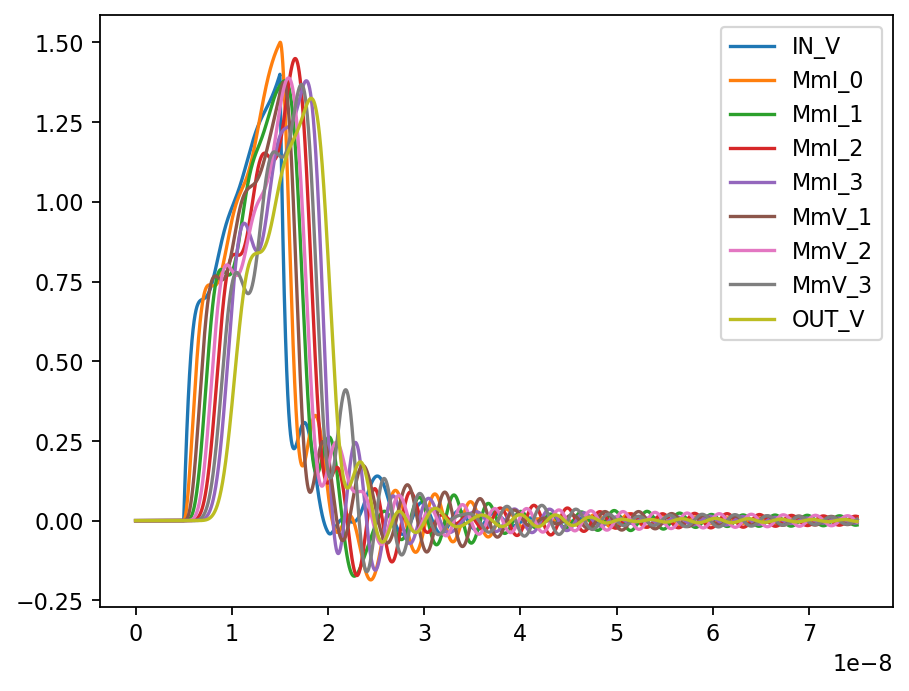

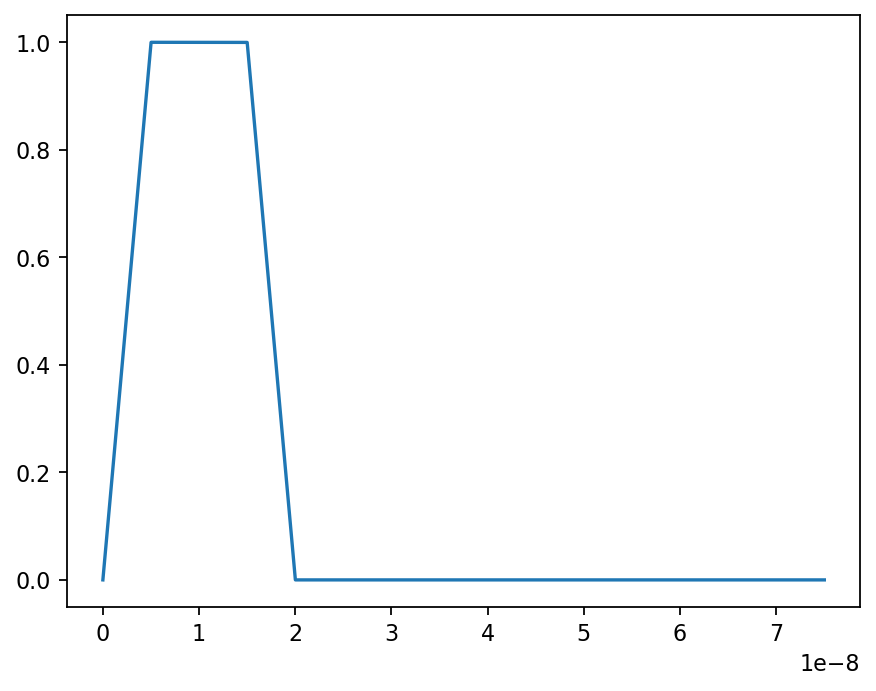

In [24]:
def lambdify_evaluate(expr: sp.Expr, vec_values: dict, parameter_values: dict) -> jax.Array:
    """Lambdifies a sympy equation and evaluates it with the given parameter values."""
    # Lambdify the equation
    free_symbols = list(expr.free_symbols)
    lambdified_eq = sp.lambdify(free_symbols, expr=expr, modules='jax')
    # Evaluate the equation
    evaluation_parameters = {k: parameter_values[k] if k in parameter_values else vec_values[k] for k in map(str, free_symbols)}
    return lambdified_eq(**evaluation_parameters)

@eqx.filter_jit
def solve_system(initial_values: Dict[str, float], parameter_values: Dict[str, float], saveat: dr.SaveAt) -> dict:
    initial_y = jnp.array([initial_values[k] for k in map(str, lhs_vars)])
    def f(t, y, args: dict):
        # Loop through and lambdify all equations
        vec_values = {k: y[i] for i, k in enumerate(map(str, lhs_vars))}
        args_with_t = {**args, 't': t}
        return jnp.array([lambdify_evaluate(expr=eq.rhs, vec_values=vec_values, parameter_values=args_with_t) for eq in sympy_eqs_expanded])
    
    term = dr.ODETerm(f)
    solver = dr.Tsit5()
    system_solution = dr.diffeqsolve(terms=term, solver=solver, t0=0.0, t1=75e-9, dt0=1e-13, y0=initial_y,
                                     args=parameter_values, saveat=saveat, max_steps=1_000_000)
    return system_solution

solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=keys_to_str(param_dict), saveat=dr.SaveAt(steps=True))
display(solution)
display(solution.stats)
jax.block_until_ready(solution.ys)
print('Finished getting solution!')
plt.plot(solution.ts, solution.ys)
plt.legend(lhs_vars)
plt.show()
plt.plot(solution.ts, sp.lambdify(sp.symbols('t'), pulse_sympy(sp.symbols('t')))(solution.ts))
plt.show()

In [70]:
solution.ts

Array([1.e-13, 2.e-13, 3.e-13, ...,    inf,    inf,    inf],      dtype=float64, weak_type=True)